## Data Source
https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

# Import Modules

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import csv
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn import metrics
# import datetime as dt

# Functions

In [98]:
# render dataframe as table figure
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=15,
                     header_color='#8B6900', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs, rowLabels=data.index)
    # mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

# Get summary tsble of dataframe
def get_df_summary(df):
    print(f'Data Shape: {df.shape}')
    df_desc = pd.DataFrame(df.describe(include='all')).transpose()
    summary = pd.DataFrame(df.dtypes, columns=['Data Types'])
    summary['NA Count'] = df.isnull().sum()
    summary['NA %'] = df.isnull().sum() / len(df) * 100
    summary['Unique Values'] = df.nunique()
    summary['Min'] = df_desc['min'].values
    summary['Max'] = df_desc['max'].values
    summary['Mean'] = df_desc['mean'].values
    summary['Skewness'] = df.skew(numeric_only=True)
    summary.index.name = 'Columns'
    return summary


# Load Datasets

## features.csv

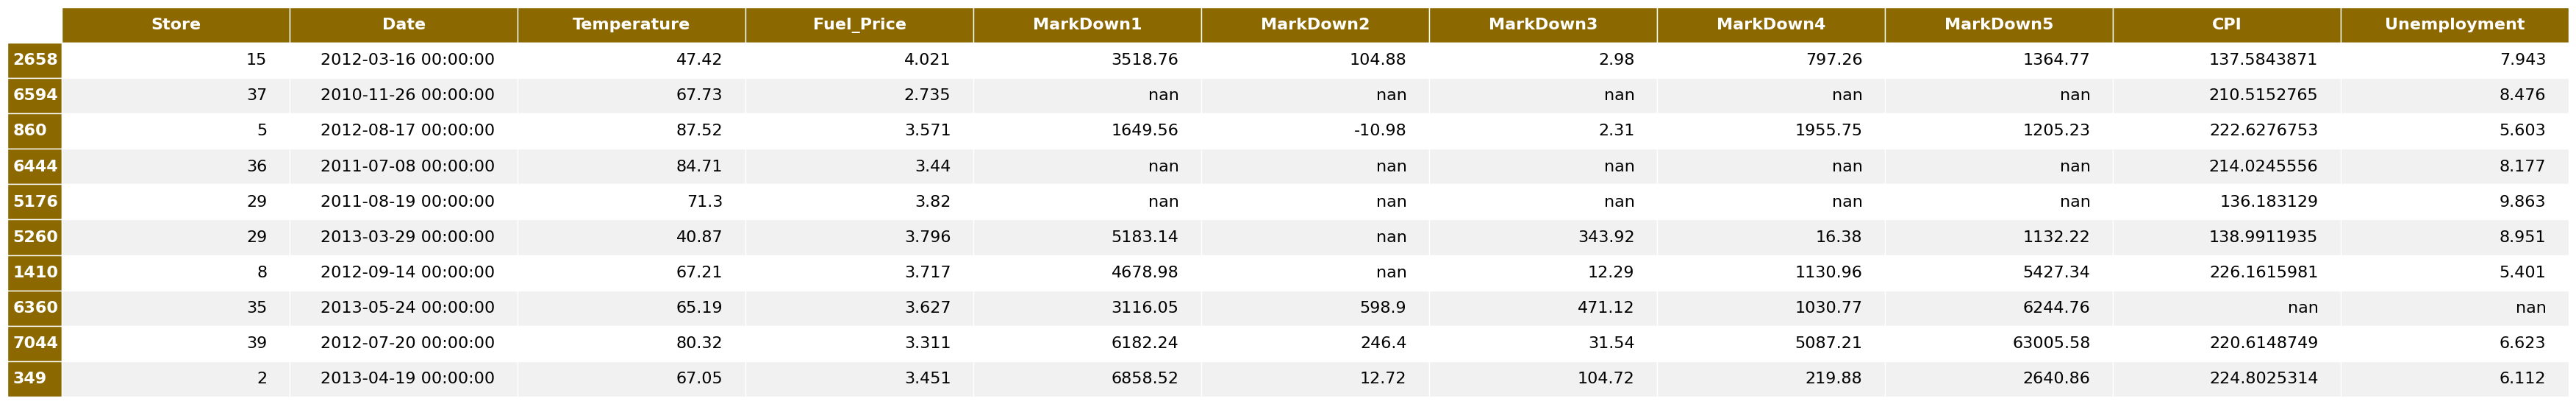

In [209]:
feat_df = pd.read_csv('features.csv', parse_dates=['Date']).drop(columns=['IsHoliday'])
# feat_df = pd.read_csv('FeaturesDataset.csv', parse_dates=['Date']).drop(columns=['IsHoliday'])
feat_df.head()
fig,ax = render_mpl_table(feat_df.sample(10), header_columns=0, col_width=4.0, font_size=16)


### Summary of features.csv

Data Shape: (8190, 11)


(<Figure size 3200x750 with 1 Axes>, <Axes: >)

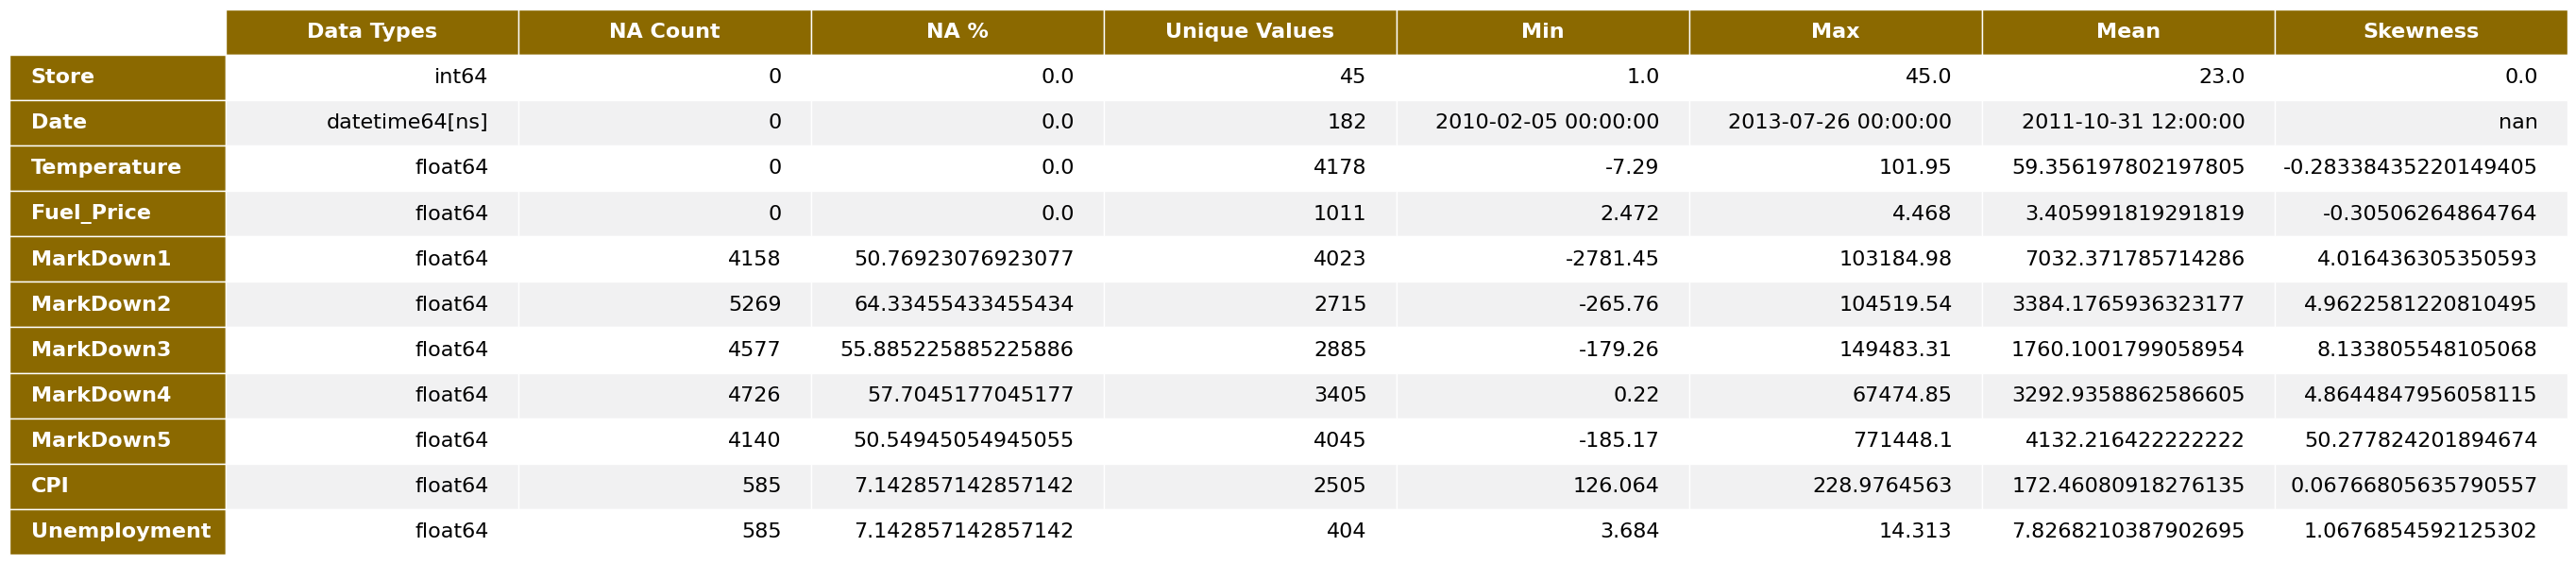

In [210]:
summary = get_df_summary(feat_df)
render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

## train.csv

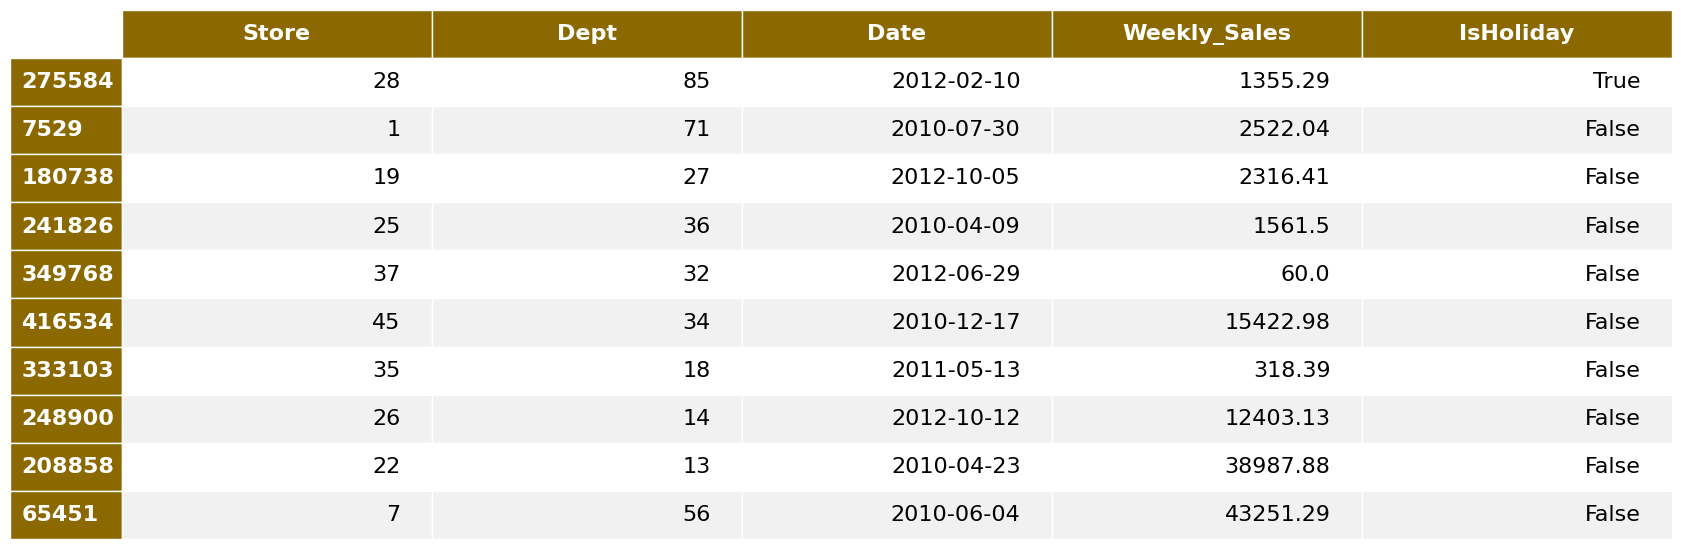

In [211]:
train_df = pd.read_csv('train.csv')
fig,ax = render_mpl_table(train_df.sample(10), header_columns=0, col_width=4.0, font_size=16)
# fig,ax = render_mpl_table(train_df.sample(10), header_columns=0, col_width=4.0, font_size=16)

### Summary 0f train.csv

Data Shape: (421570, 5)


(<Figure size 3200x375 with 1 Axes>, <Axes: >)

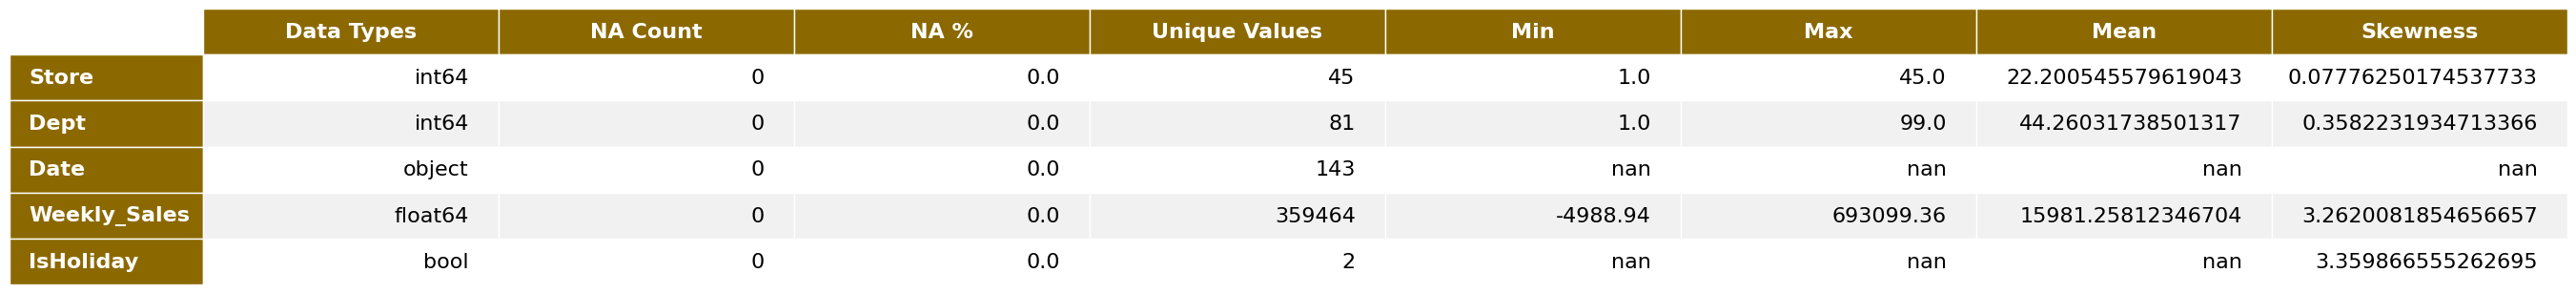

In [212]:
summary = get_df_summary(train_df)
render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

* Convert Date column to datetime type

In [131]:
train_df['Date'] = pd.to_datetime(train_df['Date'])


# Merge features & train df

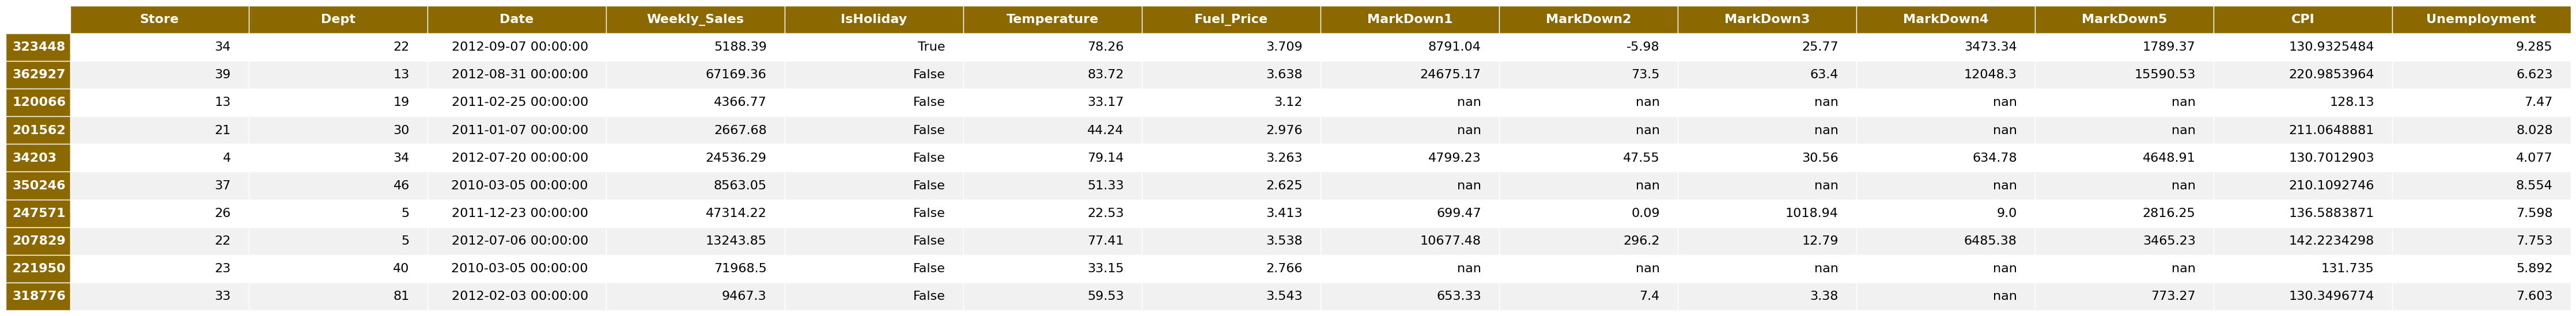

In [132]:
train_df = train_df.merge(feat_df, how='left')
fig,ax = render_mpl_table(train_df.sample(10), header_columns=0, col_width=4.0, font_size=16)

## Summary of merged dataset

Data Shape: (421570, 14)


(<Figure size 3200x937.5 with 1 Axes>, <Axes: >)

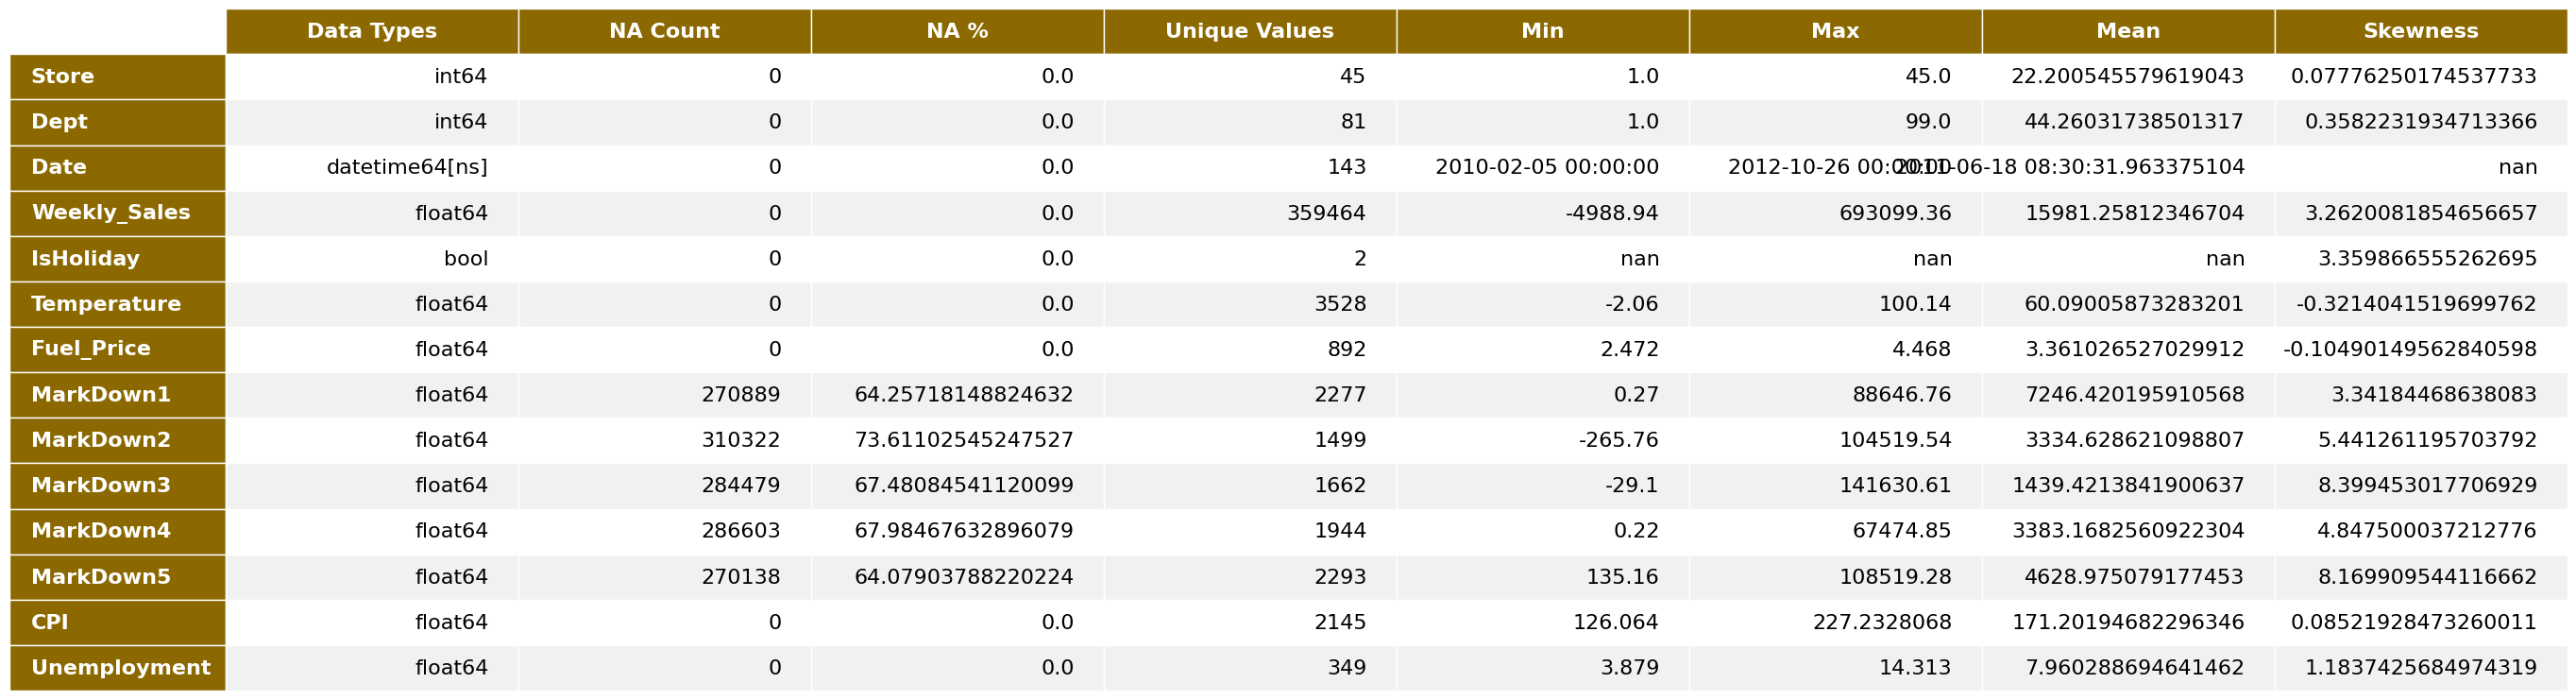

In [169]:
summary = get_df_summary(train_df)
render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

## Replace missing values with 0

Data Shape: (421570, 14)


(<Figure size 3200x937.5 with 1 Axes>, <Axes: >)

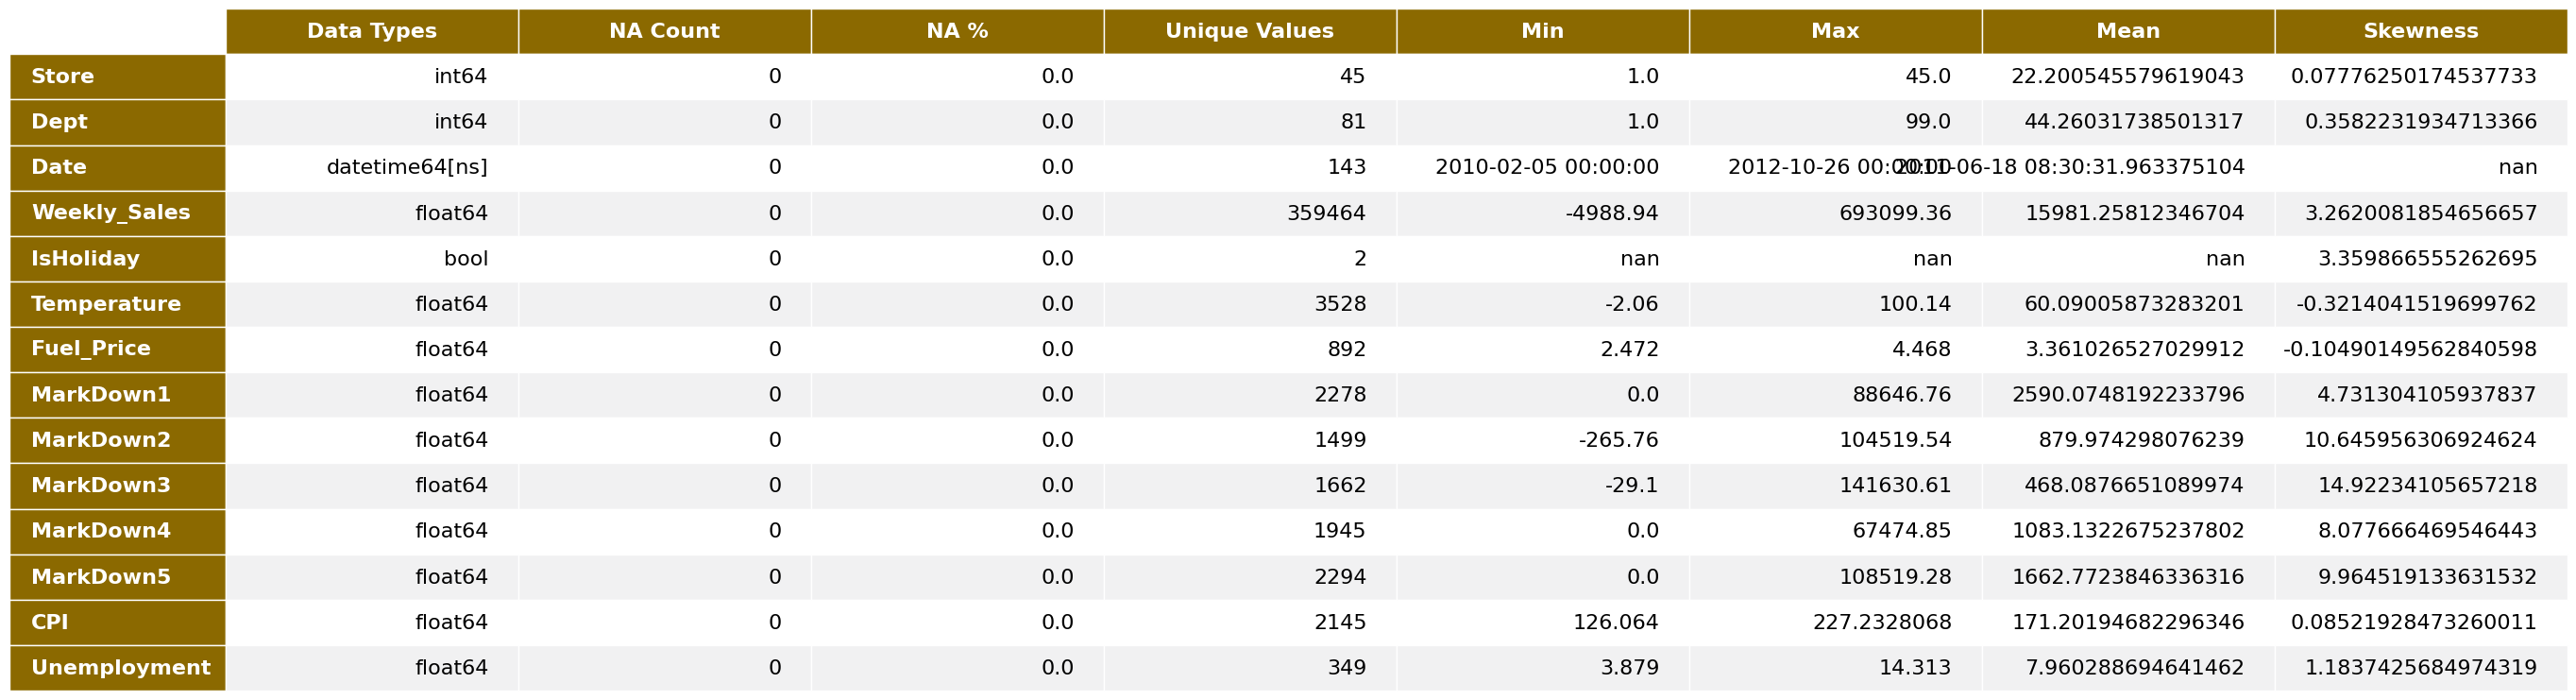

In [172]:
train_df = train_df.fillna(0)
summary = get_df_summary(train_df)
render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

# Write dataframe to CSV file

In [173]:
train_df.to_csv('merged_train.csv')

# Visualize Distibution & Relationship

## Pairplots

In [194]:
def pairplot(df, x_vars, y_vars):
    return sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, palette='coolwarm', hue='Store', diag_kind = 'auto')


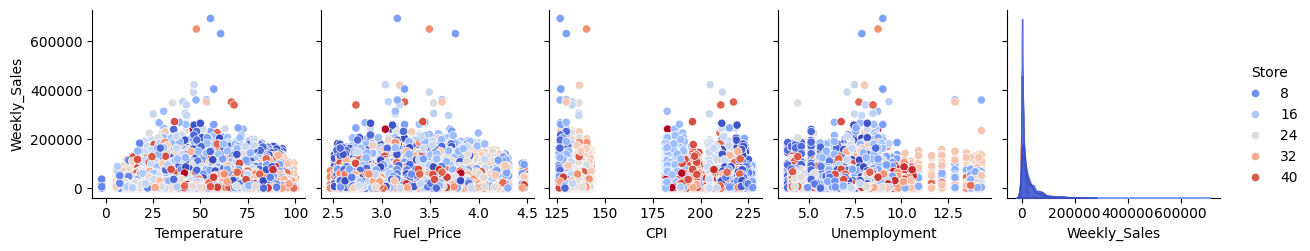

In [198]:
# sns.pairplot(train_df.sample(1000), vars=[ 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Weekly_Sales',], palette='coolwarm', hue='Store', diag_kind = 'auto')
# pairplot(train_df.sample(round(len(train_df)/2)),
#          x_vars=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales'],
#         y_vars=['Weekly_Sales'])
pairplot(train_df.sample(round(len(train_df)/2)),
         x_vars=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales'],
        y_vars=['Weekly_Sales'])


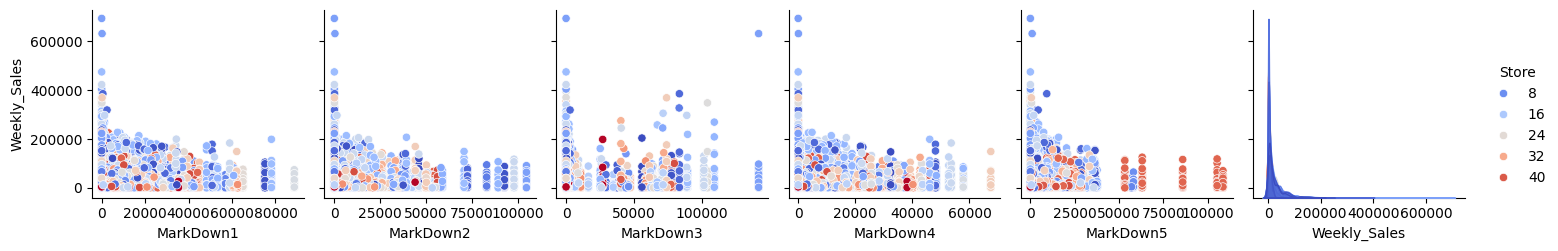

In [197]:
# sns.pairplot(train_df.fillna(0).sample(1000), vars=[ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales',], palette='coolwarm', hue='Store', diag_kind = 'kde')

pairplot(train_df.sample(round(len(train_df)/2)),
         x_vars=[ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales'], y_vars=['Weekly_Sales'])

## Correlation Heatmap

In [207]:
def heatmap(corr):
    matrix = np.triu(corr)
    plt.figure(figsize=(20,6))
    fig = sns.heatmap(corr, cmap='coolwarm', mask=matrix, annot=True, cbar=False)
    plt.show()


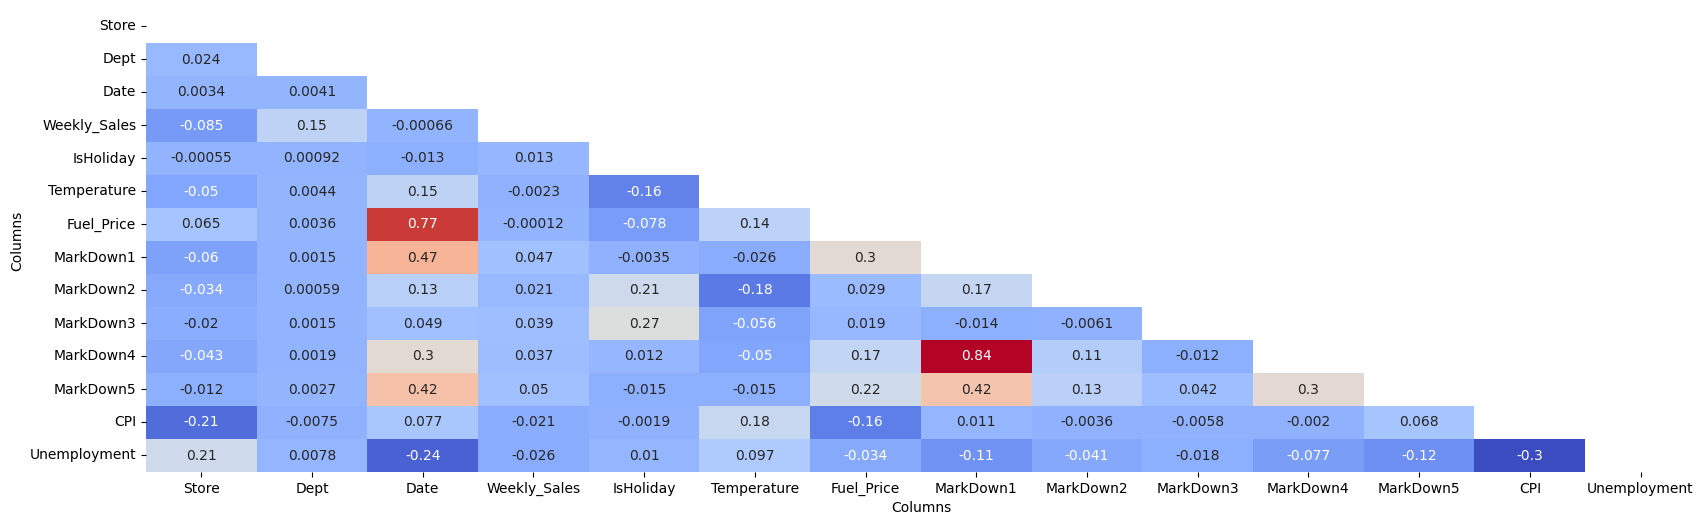

In [208]:
# fig = sns.heatmap(train_df.corr(), cmap='coolwarm')
heatmap(train_df.corr())

In [154]:
def grouped_mean_scatter_plot(df, cols, agg_by, x='Store', y='Weekly_Sales', hue='Dept'):
    grouped_data = df.groupby(cols)[agg_by].mean().reset_index()
    plt.figure(figsize=(15, 6))
    g = sns.scatterplot(x=x, y=y, hue=hue, data=grouped_data)
    # Customize the plot
    plt.xlabel('Store')
    plt.ylabel('Sales')
    plt.title('Sales Grouped by Store and Department')
    plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def grouped_mean_bar_plot(df, cols, agg_by, x='Store', y='Weekly_Sales', hue='Dept'):
    grouped_data = df.groupby(cols)[agg_by].mean().reset_index()
    grouped_data['Store'] = grouped_data['Store'].astype(int)
    grouped_data['Dept'] = grouped_data['Dept'].astype(int)
    # Bar chart using Seaborn
    plt.figure(figsize=(20, 6))
    sns.barplot(x=x, y=y, hue=hue, data=grouped_data, width=1.0)

    # Customize the plot
    plt.xlabel('Store')
    plt.ylabel('Sales')
    plt.title('Sales Grouped by Department and Store')
    plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



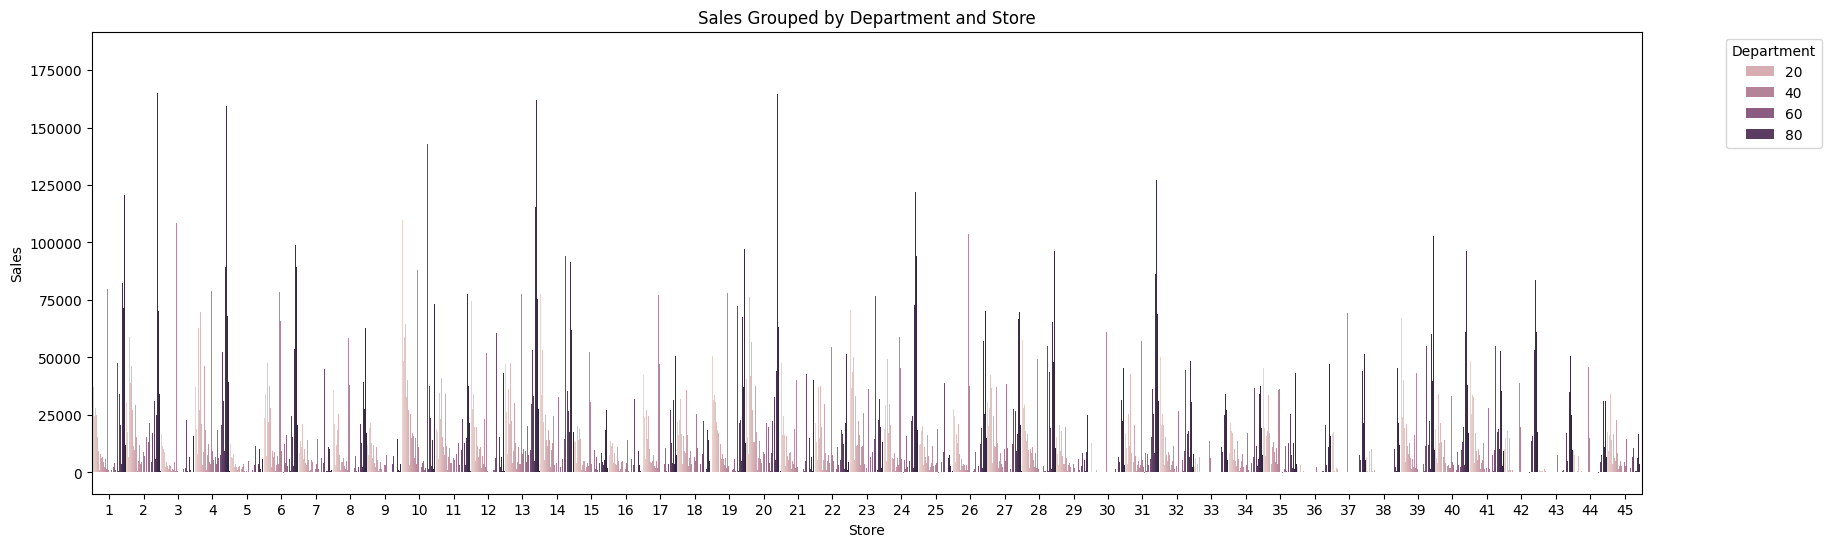

In [153]:
grouped_mean_bar_plot(train_df, ['Store', 'Dept'], 'Weekly_Sales' )

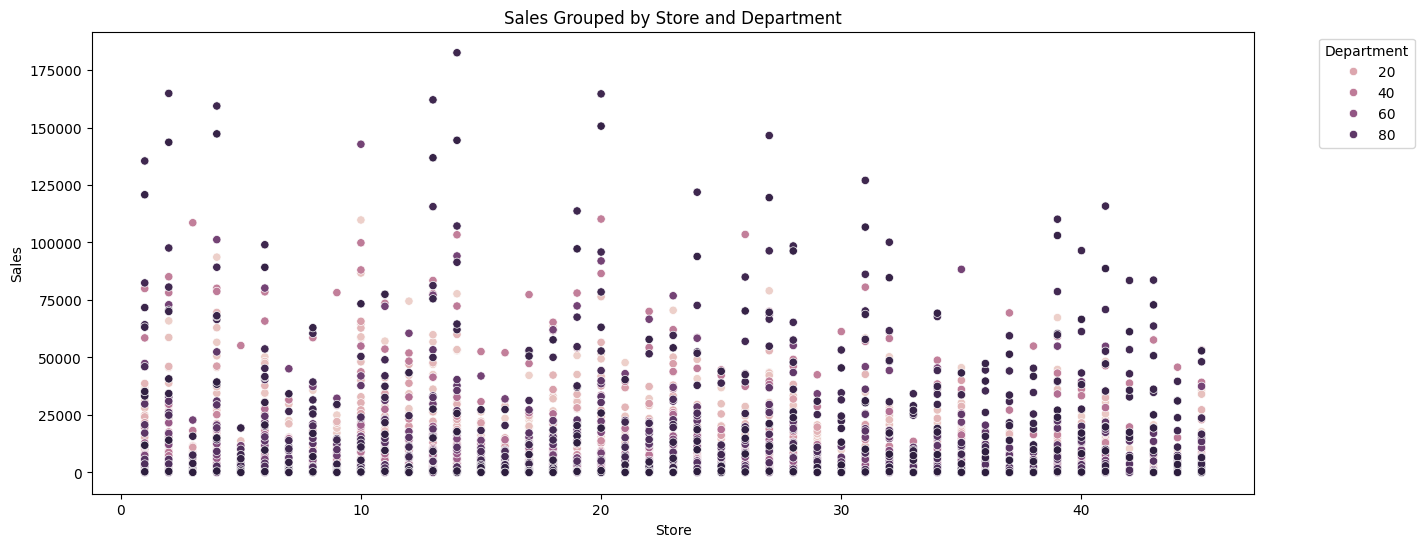

In [155]:
grouped_mean_scatter_plot(train_df, ['Store', 'Dept'], 'Weekly_Sales')


# IGNORE

## Test data

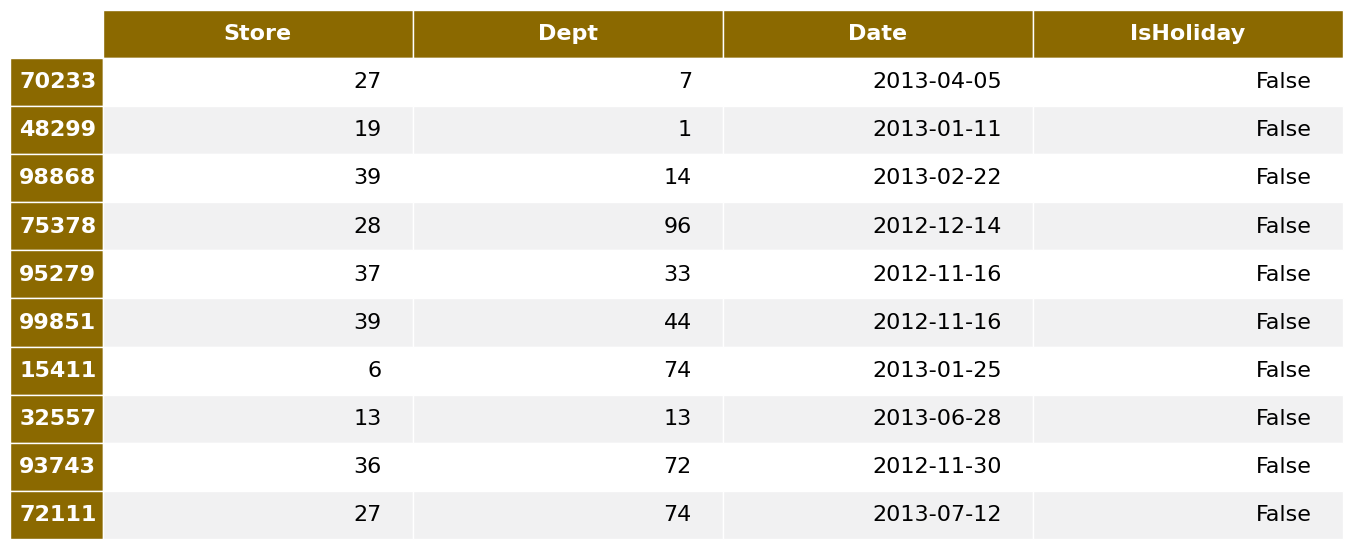

In [157]:
test_df = pd.read_csv('test.csv')
fig,ax = render_mpl_table(test_df.sample(10), header_columns=0, col_width=4.0, font_size=16)

Data Shape: (115064, 4)


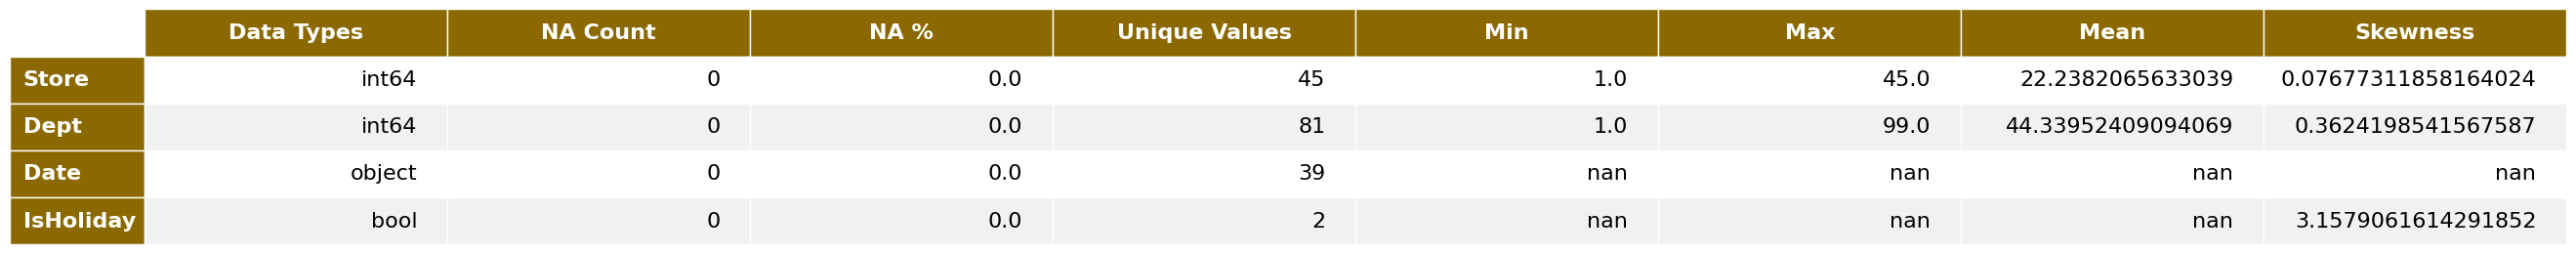

In [158]:
summary = get_df_summary(test_df)
fig,ax = render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

In [165]:
test_df['Date'] = pd.to_datetime(test_df['Date'])

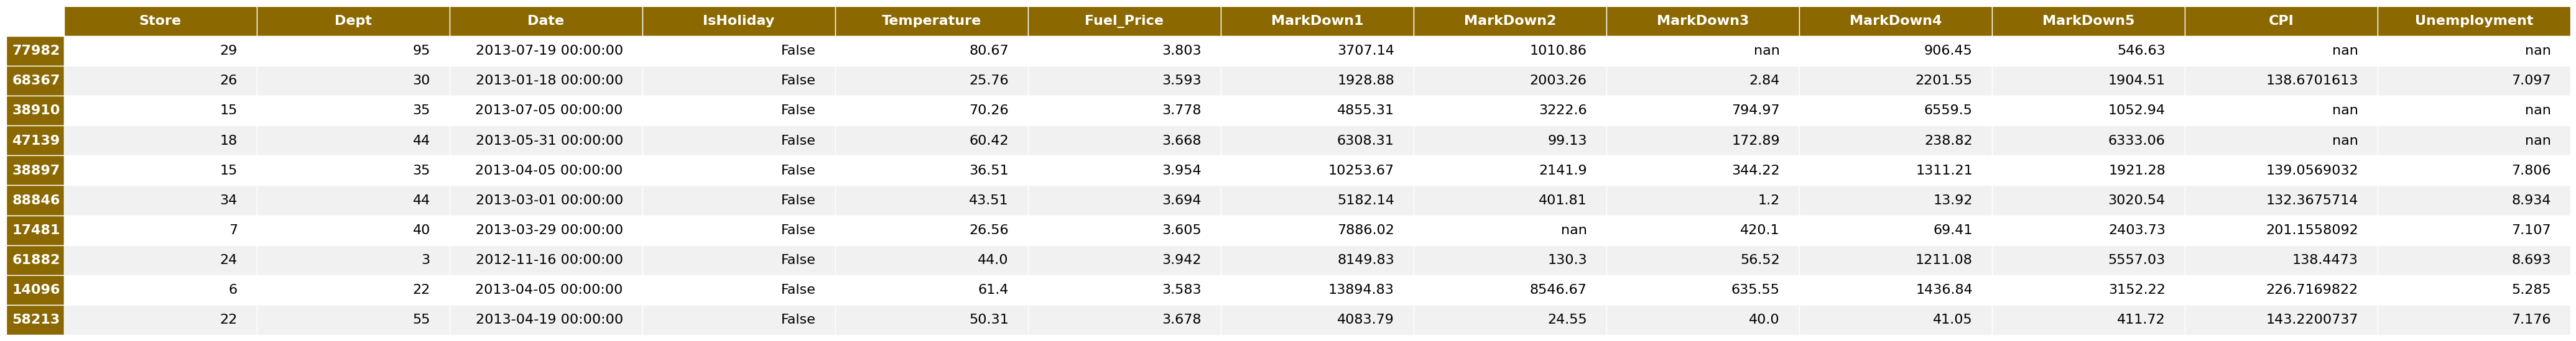

In [166]:
test_df = test_df.merge(feat_df, how='left')
fig,ax = render_mpl_table(test_df.sample(10), header_columns=0, col_width=4.0, font_size=16)


In [137]:
# test_df.to_csv('merged_test.csv')

Data Shape: (115064, 13)


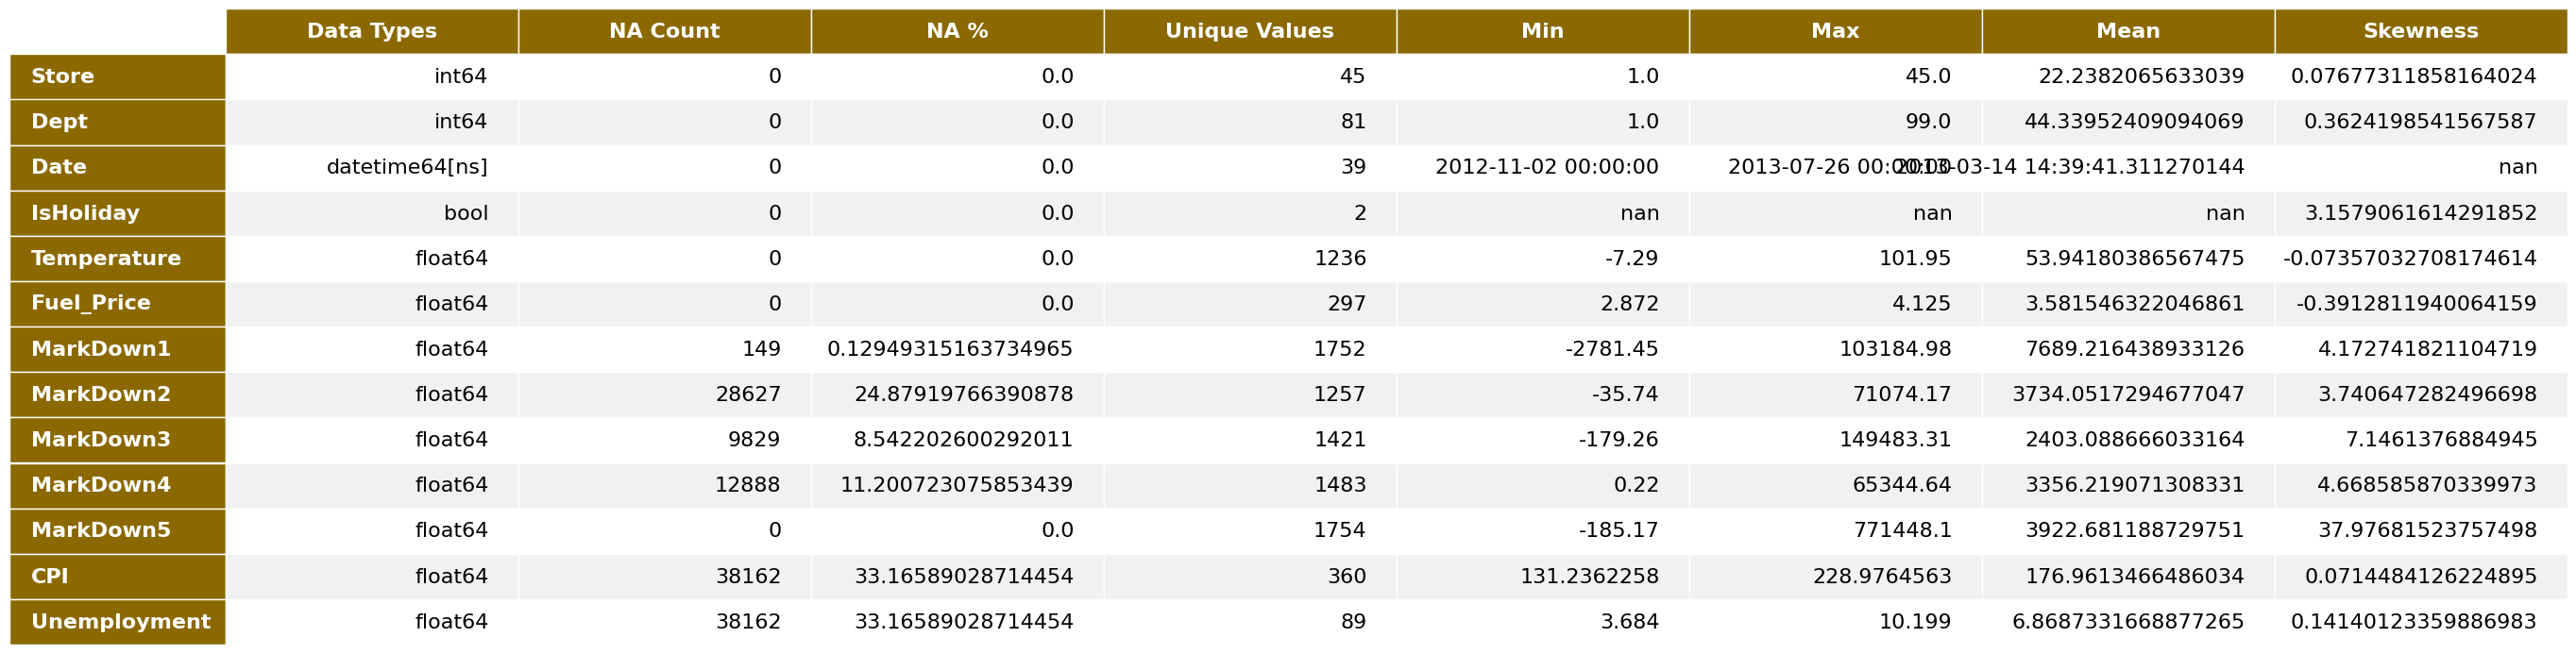

In [167]:
summary = get_df_summary(test_df)
fig,ax = render_mpl_table(summary, header_columns=0, col_width=4.0, font_size=16)

In [42]:
def get_unique_values(df, col):
    print('Column: ', col)
    result = dict(df[col].value_counts(dropna=True))
    print("{:<30} {:<10} ".format('Values','Count'))
    for key, val in result.items():
        print("{:<30} {:<10} ".format(key,val))

In [ ]:
# get_unique_values(feat_df, 'Store')
# get_unique_values(feat_df, 'IsHoliday')

In [ ]:
# get_unique_values(sales_df, 'Store')
# get_unique_values(sales_df, 'Dept')
# get_unique_values(sales_df, 'IsHoliday')

In [ ]:
for name, group in train_df.groupby(['Store', 'Dept']):

# fig,ax = render_mpl_table(grouped, header_columns=0, col_width=2.0, font_size=16)

    fig = sns.scatterplot(x=range(len(group)), y=group['Weekly_Sales'])
    # sns.move_legend(obj=fig, loc='right', bbox_to_anchor=(1.5, -0.45), ncol=10, title='Department Id')
    plt.title(name)
    # plt.xlabel('Store')
    plt.ylabel('Weekly Sales')
    plt.show()
    break



In [ ]:
# pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [254]:
# def imputeNull(drop_col, impute_col, df, test_col):
#     # df.set_index('Date')
#     print(df.info)
#     lin_r = LinearRegression()
#     temp_df = df.drop(drop_col, axis='columns')

#     test_df = temp_df.loc[temp_df[impute_col].isnull()==True]
#     train_df = temp_df.loc[temp_df[impute_col].isnull()==False]
#     y = train_df[impute_col]
#     train_df = train_df.drop(impute_col, axis=1)
#     lin_r.fit(train_df, y)
#     test_df = test_df.drop(impute_col, axis=1)
#     # print(test_df.isnull().sum(), train_df.isnull().sum())
#     pred = lin_r.predict(test_df)
#     test_df[impute_col] = pred

#     train_df[impute_col] = y
#     print(train_df.head())
#     y = train_df[test_col]
#     train_df.drop(test_col, axis=1)

#     log_r = LogisticRegression(max_iter=1000)
#     log_r.fit(train_df, y)

#     LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
#                    warm_start=False)
#     y_test = test_df[test_col]
#     test_df.drop(test_col, axis=1)
#     pred = log_r.predict(test_df)
#     print(metrics.accuracy_score(pred, y_test))





In [ ]:

# merged_df = merged_df.index.to_julian_date()

# imputeNull(['Unemployment', 'CPI', 'Weekly_Sales' ], 'Dept', merged_df, 'Store')

### IGNORE!!!!

In [ ]:
cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
plt.figure(figsize=(8, 5))
for col in cols:
    sns.histplot(data=feat_df, x=col)
    plt.title('Distribution of' + col)
    plt.xlabel(col)
    plt.ylabel("Values")
    plt.show()